# Random-graph UD-MIS (Classical)

$$
H = -\sum_{i \in V} n_i + u \sum_{i,j \in E} n_i n_j
$$

Our goal is to find one of the ground state(s) - a solution to the UD-MIS problem - automatically through Monte Carlo sampling.

The probability distribution of the Ising model at temperature $T$ is given by the Gibbs distribution:

$$p(\sigma; T) = \frac{1}{Z(T)}\exp\left(-\frac{H(\sigma)}{T}\right)$$,

where $Z(T)$ is the normalization constant (also known as the *partition function*).

In [366]:
import numpy as np
import matplotlib.pyplot as plt
from abstract_udmis import AbstractUDMIS
import time

# https://networkx.org/documentation/stable/index.html
from networkx.algorithms.approximation import independent_set

# https://igraph.org/python/doc/api/igraph._igraph.GraphBase.html#independent_vertex_sets
import igraph

%matplotlib inline

Below you'll find code for the UDMIS model of interest. Strictly speaking, for the purposes of performing the Monte Carlo simulation we can simply compute the required energy differences using two calls to the energy function. However, we can often save significant computation time by writing a specialised function for the energy difference that avoids unnecessary calculations. Simply put, calculating the energy of a configuration of occupations requires you to iterate over all vertices in the graph, but the energy change associated with a single-occupation-flip can be computed just from values of the connected vertices.

In [61]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
#         print("num_vertices:",self.num_vertices)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def find_edges(self):
        #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices)
    
    def mc_step(self, T):
        """Performs a full update of the Rydberg model using the Metropolis-Hastings algorithm"""
        current_energy = self.energy()
        for k in range(self.num_vertices):
            vertex = self.rand_vertex()
            dE = self.energy_diff(vertex)

            if (dE < 0) or (np.random.rand() < np.exp(-dE / T)): # Set the condition for acception or rejection
                current_energy += dE
                self.occupations[vertex] ^= 1 
                # flips occupation 0 --> 1 OR 1 --> 0
        return current_energy

In [424]:
def run_annealing(udmis, N=5000, T_i=100, T_f=0.01,verbose=False, 
                  plot_annealing=True, plot_occupation=True, annotate=False):

#     N = 5000
    t = np.arange(N+1)
#     T_i = 100
#     T_f = 0.01

    T = T_i * ((T_f/T_i) ** (t/N))

    temp_ = []
    E_ = []
    tik = time.time()
    for t in range(N):
        # take a look at the abstract_udmis.py file to see how mc_step works
        temp = T[t]
        temp_.append(temp)
        E = udmis.mc_step(T=temp)
        E_.append(E)
        if verbose and t % 300 == 0:
            print(t, E)
    tok = time.time()
    if plot_annealing:
        fig=plt.figure(figsize = (12,3))
        ax = fig.add_subplot(121)
        plt.plot(temp_, E_)
        plt.xscale('log')
        ax.invert_xaxis()
        plt.xlabel('Temperature (K)')
        plt.ylabel('Energy')
        plt.title('Simulated Annealing (Run time: {:0.5f} sec)\nNumber of annealing steps: {:d}\nu={:0.2f}, T_i={:0.1f}K, T_f={:0.2f}K'.format(tok-tik, N, udmis.u, T_i, T_f))
    
    
    if plot_occupation:
        occupation = udmis.occupations
        ax = fig.add_subplot(122, aspect =1)
        for i in range(len(graph)):
            x,y = graph[i]
            circle = plt.Circle((x,y), 0.5, alpha = 0.9 if occupation[i] else 0.1,
                                facecolor='r' if occupation[i] else 'b',fill=True)
            ax.add_patch(circle)
            if annotate:
                plt.text(x,y, i+1, fontsize=8)
        plt.title('Number of Vertices: {:d}\nSize of the MIS: {:d}'.format(len(graph),sum(occupation)))
        ax.autoscale()
        plt.show()
    
    return temp_, E_

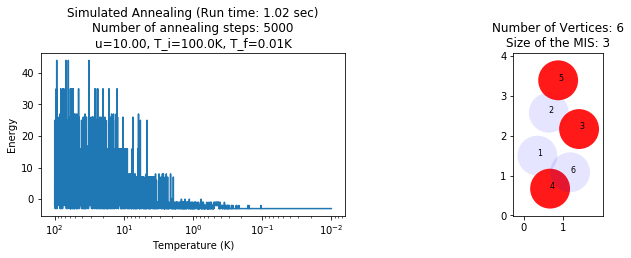

In [63]:
u = 10
graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]

udmis = UDMIS(u, graph)
run_annealing(udmis, annotate=True);

## More complex graphs

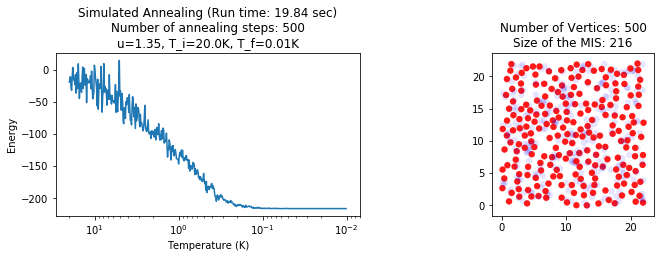

In [425]:
u = 1.35
num_vertices = 500
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
udmis = UDMIS(u, graph)
run_annealing(udmis, N=500, T_i=20, T_f=0.01);

## Varying the number of steps, i.e. cooling speed

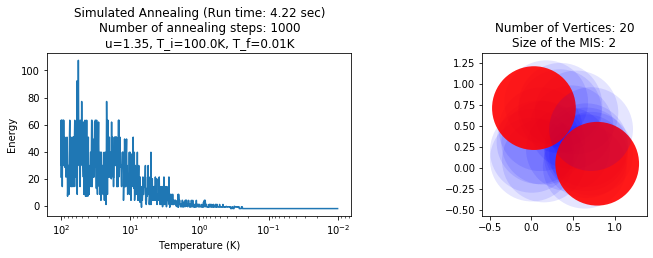

In [116]:
u = 1.35
num_vertices = 20
graph = []
graph_length = int(np.sqrt(num_vertices))*0.2
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
udmis = UDMIS(u, graph)
run_annealing(udmis, N=1000, T_i=100, T_f=0.01);

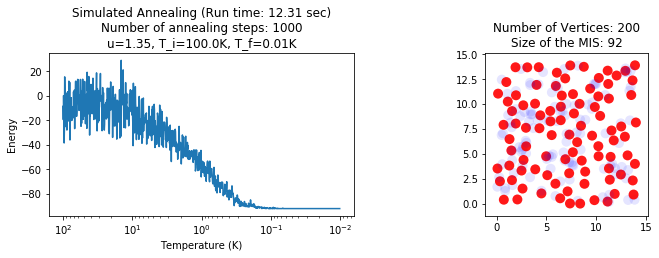

In [419]:
u = 1.35
num_vertices = 200
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
udmis = UDMIS(u, graph)
run_annealing(udmis, N=1000, T_i=100, T_f=0.01);

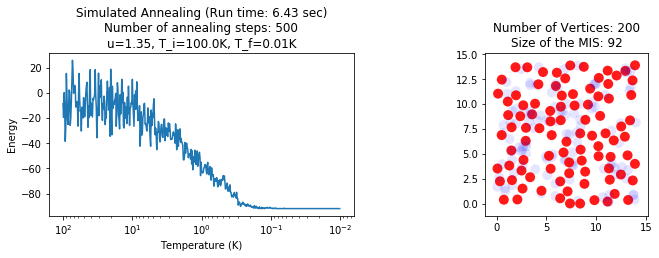

In [420]:
u = 1.35
num_vertices = 200
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
udmis = UDMIS(u, graph)
run_annealing(udmis, N=500, T_i=100, T_f=0.01);

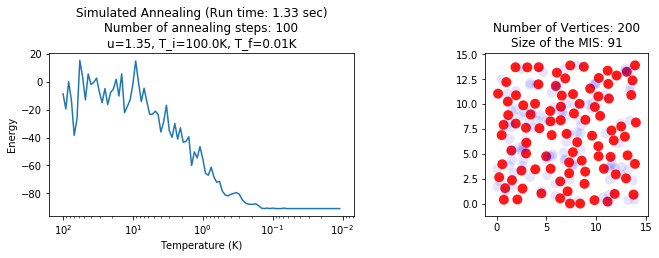

In [416]:
u = 1.35
num_vertices = 200
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
udmis = UDMIS(u, graph)
run_annealing(udmis, N=100, T_i=100, T_f=0.01);

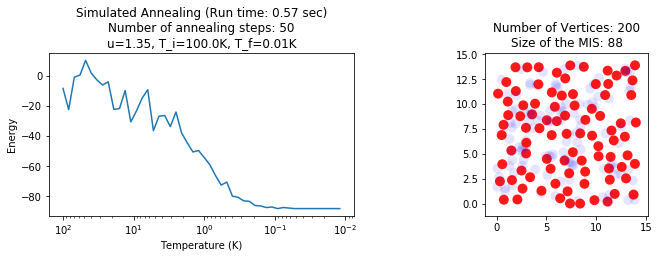

In [417]:
u = 1.35
num_vertices = 200
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
udmis = UDMIS(u, graph)
run_annealing(udmis, N=50, T_i=100, T_f=0.01);

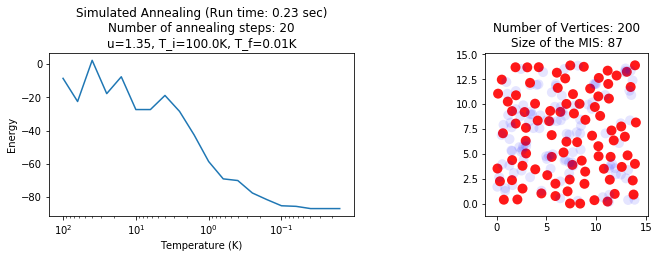

In [418]:
u = 1.35
num_vertices = 200
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
udmis = UDMIS(u, graph)
run_annealing(udmis, N=20, T_i=100, T_f=0.01);

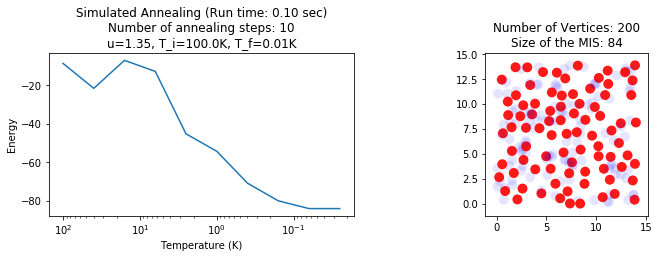

In [421]:
u = 1.35
num_vertices = 200
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
udmis = UDMIS(u, graph)
run_annealing(udmis, N=10, T_i=100, T_f=0.01);

## Varying the parameter u

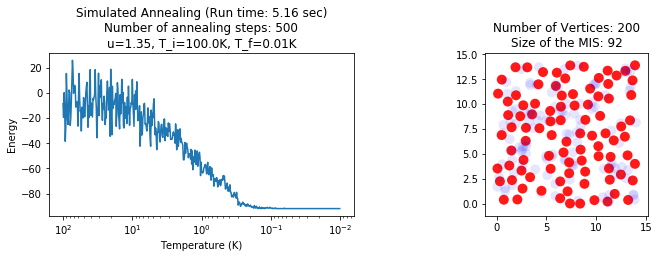

In [405]:
u = 1.35
num_vertices = 200
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
udmis = UDMIS(u, graph)
run_annealing(udmis, N=500, T_i=100, T_f=0.01);

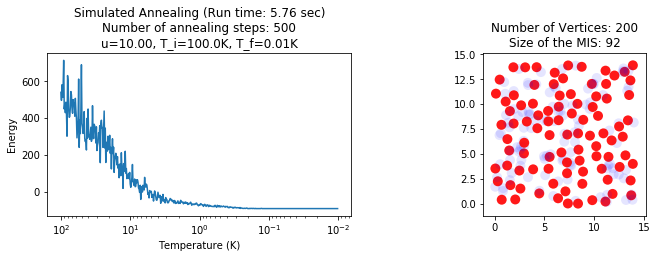

In [406]:
u = 10
num_vertices = 200
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
udmis = UDMIS(u, graph)
run_annealing(udmis, N=500, T_i=100, T_f=0.01);

The size of the MIS is not correct now. This indicates u is too large.

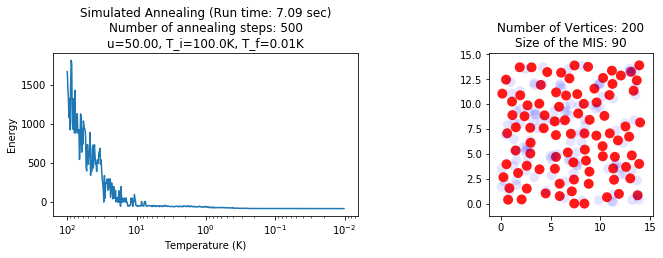

In [412]:
u = 50
num_vertices = 200
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
udmis = UDMIS(u, graph)
run_annealing(udmis, N=500, T_i=100, T_f=0.01);

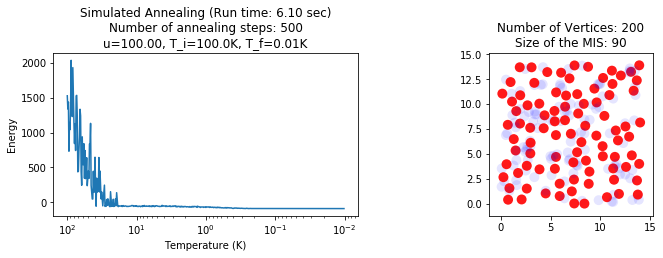

In [410]:
u = 100
num_vertices = 200
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
udmis = UDMIS(u, graph)
run_annealing(udmis, N=500, T_i=100, T_f=0.01);

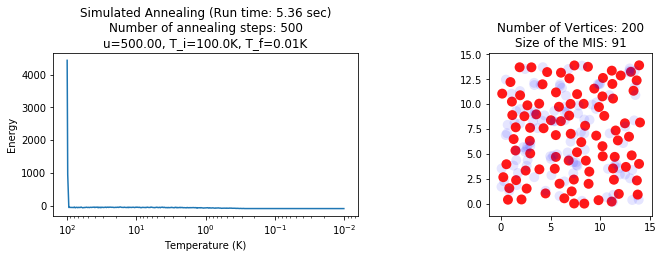

In [411]:
u = 500
num_vertices = 200
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
udmis = UDMIS(u, graph)
run_annealing(udmis, N=500, T_i=100, T_f=0.01);

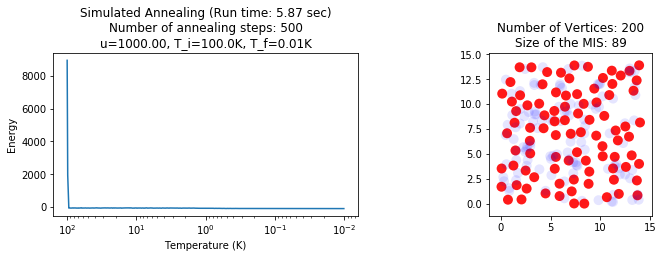

In [419]:
u = 1000
num_vertices = 200
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
udmis = UDMIS(u, graph)
run_annealing(udmis, N=500, T_i=100, T_f=0.01);

# Task 3

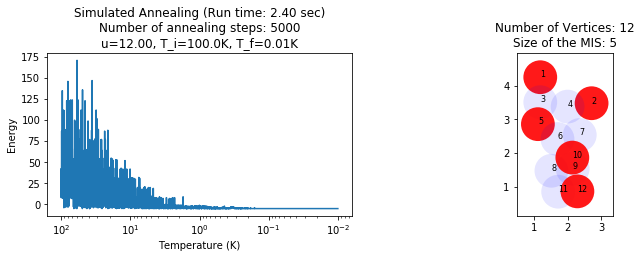

In [424]:
u = 12
graph = [(1.19, 4.25), 
         (2.71, 3.48), 
         (1.19, 3.51), 
         (2,3.38), 
         (1.12, 2.86), 
         (1.70, 2.42),
         (2.36, 2.54),
         (1.52, 1.48),
         (2.15, 1.54),
         (2.14, 1.87),
         (1.72, 0.86),
         (2.29, 0.87),
        ]

udmis = UDMIS(u, graph)
run_annealing(udmis, annotate=True);

## Compare with other classical algorithms
### Approximate Solution by NetworkX

Independent set algorithm is based on the following paper:

𝑂(|𝑉|/(𝑙𝑜𝑔|𝑉|)2) apx of maximum clique/independent set.

Boppana, R., & Halldórsson, M. M. (1992). Approximating maximum independent sets by excluding subgraphs. BIT Numerical Mathematics, 32(2), 180–196. Springer. doi:10.1007/BF01994876
https://link.springer.com/article/10.1007%2FBF01994876

In [428]:
import networkx as nx
def networkx_mis(graph, annotate=False):
    edges = []
    for i in range(len(graph)):
        for j in range(i+1, len(graph)):
            dij = np.sqrt((graph[i][0] - graph[j][0])**2 + (graph[i][1] - graph[j][1])**2)
            if dij<=1:
                edges.append((i,j))
    G = nx.Graph()
    G.add_edges_from(edges)
    tik = time.time()
    MIS = independent_set.maximum_independent_set(G)
    tok = time.time()
    udmis = UDMIS(u, graph)

    fig=plt.figure(figsize = (8,4))
    ax = fig.add_subplot(121)
    nx.draw(G, with_labels=True, node_size=50, nodelist = G.nodes, alpha=1,
           node_color=['r' if i in MIS else 'b' for i in G.nodes])
    ax.set_title('Approximate Solution by NetworkX\nRun time: {:0.5f} sec'.format(tok-tik))
    ax = fig.add_subplot(122, aspect =1)

    for i in range(len(graph)):
        x,y = graph[i]
        circle = plt.Circle((x,y), 0.5, alpha = 0.9 if i in MIS else 0.1,
                                    facecolor='r' if i in MIS else 'b',fill=True)
        ax.add_patch(circle)
        if annotate:
            plt.text(x,y, i, fontsize=8)
        plt.title('Number of Vertices: {:d}\nSize of the MIS: {:d}'.format(len(graph),len(MIS)))
        ax.autoscale()
    plt.show()
    return G


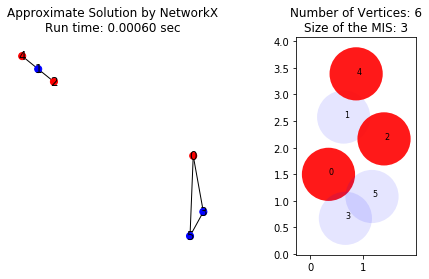

In [429]:
graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]
G=networkx_mis(graph, True)

#### More complex graphs

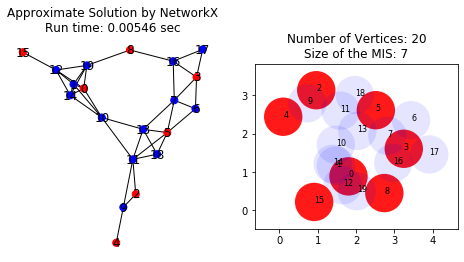

In [430]:
num_vertices = 20
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(300)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
networkx_mis(graph, True);

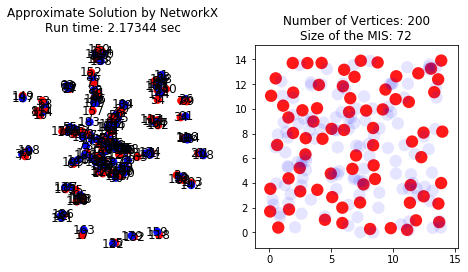

In [431]:
num_vertices = 200
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(100)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
networkx_mis(graph);

### Exact Solution from iGraph
exact solution. "The current implementation was ported to igraph from the Very Nauty Graph Library by Keith Briggs and uses the algorithm from the paper S. Tsukiyama, M. Ide, H. Ariyoshi and I. Shirawaka. A new algorithm for generating all the maximal independent sets. SIAM J Computing, 6:505–517, 1977".

processing time and memory space are bounded by $O(nm\mu)$ and $O(n+m)$, respectively, where n, m, and $\mu$ are the numbers of vertices, edges, and maximal independent sets of a graph.


Read More: https://epubs.siam.org/doi/abs/10.1137/0206036?journalCode=smjcat

In [409]:
def igraph_mis(graph, annotate=False):
    edges = []
    for i in range(len(graph)):
        for j in range(i+1, len(graph)):
            dij = np.sqrt((graph[i][0] - graph[j][0])**2 + (graph[i][1] - graph[j][1])**2)
            if dij<=1:
                edges.append((i,j))
    
    g = igraph.Graph()
    g.add_vertices(len(graph))
    g.add_edges(edges)
    tik = time.time()
    MIS = g.largest_independent_vertex_sets()[0]
    tok = time.time()
    visual_style = {"vertex_label": [i for i in range(len(graph))], 
                    "vertex_size": 10,"bbox":(200, 200), "margin":20,
                   "vertex_color": ['red' if i in MIS else 'blue' for i in range(len(graph))]}
    fig=plt.figure(figsize = (8,4))
    ax = fig.add_subplot(121)
    igraph.plot(g, **visual_style, target=ax)
    ax.set_title('Exact Solution by igraph\nRun time: {:0.5f}sec'.format(tok-tik))
    ax = fig.add_subplot(122, aspect =1)
    for i in range(len(graph)):
        x,y = graph[i]
        circle = plt.Circle((x,y), 0.5, alpha = 0.9 if i in MIS else 0.1,
                            facecolor='r' if i in MIS else 'b',fill=True)
        ax.add_patch(circle)
        if annotate:
            plt.text(x,y, i, fontsize=8)
        plt.title('Number of Vertices: {:d}\nSize of the MIS: {:d}'.format(len(graph),len(MIS)))
        ax.autoscale()
    plt.show()

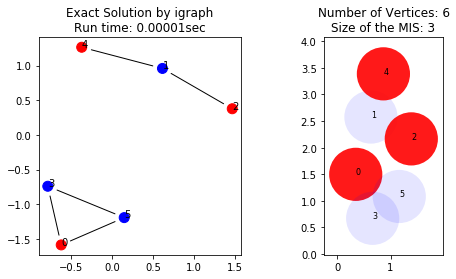

In [410]:
graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]
igraph_mis(graph, True)

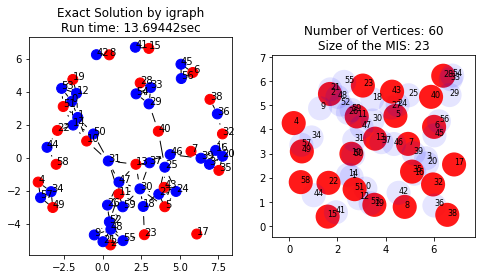

In [415]:
num_vertices = 60
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(300)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))
igraph_mis(graph, True);

# Put everything together

In [433]:
num_vertices = 60
graph = []
graph_length = int(np.sqrt(num_vertices))*1
np.random.seed(300)
for i in range(num_vertices):
    graph.append((np.random.rand()*graph_length, np.random.rand()*graph_length))

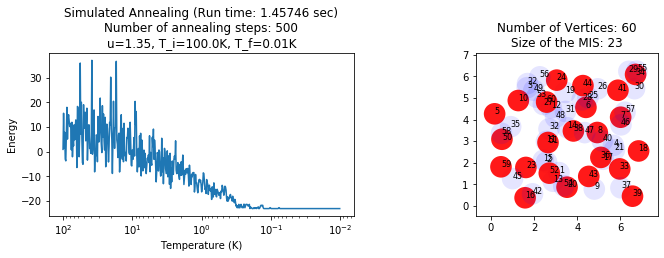

In [426]:
u=1.35
udmis = UDMIS(u, graph)
run_annealing(udmis, N=500, T_i=100, T_f=0.01, annotate=True);

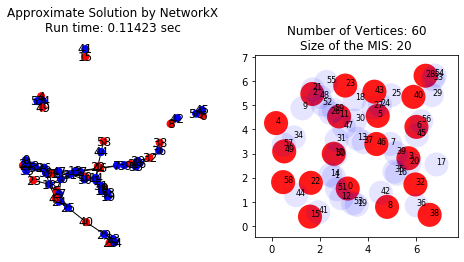

In [434]:
networkx_mis(graph, True);

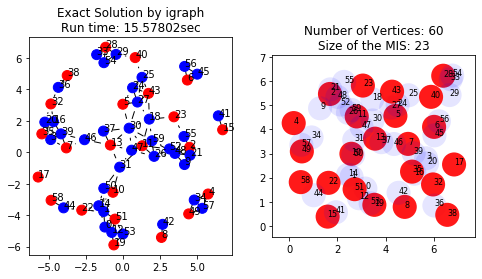

In [423]:
igraph_mis(graph, True);